# Нечеткий логический контроллер

Одним из примеров использования нечеткой логики является нечеткий логический контроллер,
который может быть использован для управления техническими устройствами.

Рассмотрим его использование на примере робота, движущегося по линии, используя библиотеку [fuzzypy](https://pypi.org/project/fuzzypy/).

## Порядок построения на примере кондиционера

В качестве примера используем кондиционер.

Для начала установим необходимые библиотеки:

In [114]:
%pip install matplotlib
%pip install fuzzypy

и импортируем их

In [115]:
import matplotlib.pyplot as plt

from fuzzypy.defuzzification import defuzzify, center_of_gravity, first_maximum
from fuzzypy.memberships import TriFunc, TrapecFunc
from fuzzypy.variables import FuzzyVariable, FuzzyRule, build_resulting_fuzzy_term
from fuzzypy.implications import larsen, mamdani

## Определение нечетких переменных и их функций принадлежности

Мы будем использовать следующие переменные:

* температура в комнате (`fuzzy_temp`)
* влажность в комнате (`fuzzy_humidity`)
* скорость вентилятора (`fuzzy_blow`)
* скорость помы для откачки конденсата (`fuzzy_pump`)

Здесь `fuzzy_temp` и `fuzzy_humidity` - входные переменные, а `fuzzy_blow` и `fuzzy_pump` - выходные.

Создадим их:

In [116]:
fuzzy_temp = FuzzyVariable()  # Temperature
fuzzy_humidity = FuzzyVariable()  # Humidity
fuzzy_blow = FuzzyVariable()  # Fan speed
fuzzy_pump = FuzzyVariable()  # Pump speed

## Функции принадлежности (нечеткие термины)

Определим нечеткие множества для входных и выходных переменных.

Начнем с температуры: создадим три нечетких множества - жарко, нормально и холодно

In [117]:
hot = TrapecFunc(20, 30, 49, 50)  # триангулярная функция принадлежности
norm = TriFunc(15, 20, 25)
cold = TrapecFunc(0, 1, 10, 20)  # трапецеидальная функция принадлежности

и соответствующие им нечеткие термины

In [118]:
temp_is_hot = fuzzy_temp.is_(hot)  # The temperature is hot
temp_is_norm = fuzzy_temp.is_(norm)  # The temperature is normal
temp_is_cold = fuzzy_temp.is_(cold)  # The temperature is cold

давайте посмотрим, как выглядят графики этих функций принадлежности

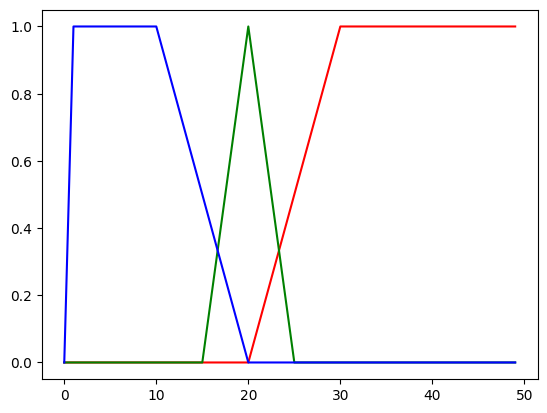

In [119]:
lower_temp_limit = int(fuzzy_temp.low_limit)  # вообще, температура имеет тип float, но рассмотрим температуру как целую величину
upper_temp_limit = int(fuzzy_temp.upp_limit)

# сгенерируем значения температуры

x = list(range(lower_temp_limit, upper_temp_limit, 1))
y_hot = [temp_is_hot(current_x) for current_x in x]  # вычисляя temp_is_hot(10), мы вычисляем значение функции принадлежности для 10
y_norm = [temp_is_norm(current_x) for current_x in x]
y_cold = [temp_is_cold(current_x) for current_x in x]

plt.plot(x, y_hot, 'r-', x, y_norm, 'g-', x, y_cold, 'b-')

аналогично для влажности

In [120]:
humidity_low = TriFunc(0, 0, 100)
humidity_high = TriFunc(0, 100, 100)

humidity_is_high = fuzzy_humidity.is_(humidity_high)
humidity_is_low = fuzzy_humidity.is_(humidity_low)

построим нечеткие множества для выходных переменных

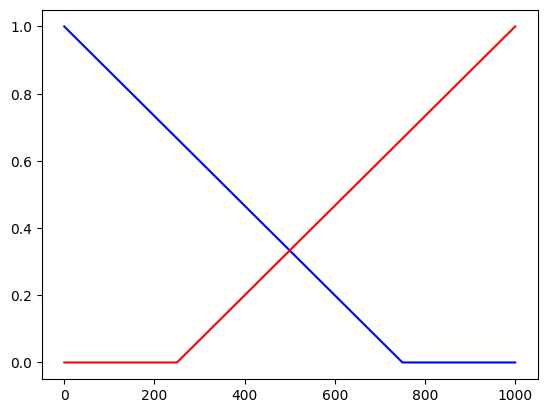

In [121]:
slow = TriFunc(0, 0, 750)  # скорость низкая
fast = TriFunc(250, 1000, 1000)  # скорость высокая

x = list(range(0, 1001, 1))
y_slow = [slow(current_x) for current_x in x]
y_fast = [fast(current_x) for current_x in x]

plt.plot(x, y_slow, 'b-', x, y_fast, 'r-')

опишем правила

In [122]:
rules = [
    FuzzyRule(temp_is_cold | temp_is_norm, fuzzy_blow, slow),  # если холодно или температура нормальная, то скорость вентилятора низкая
    FuzzyRule(temp_is_hot, fuzzy_blow, fast),  # если температура высокая, то скорость вентилятора высокая
    FuzzyRule(humidity_is_high, fuzzy_pump, fast),  # если влажность высокая, то скорость помпы высокая
    FuzzyRule(humidity_is_low, fuzzy_pump, slow),  # если влажность низкая, то скорость помпы выслкая
]

Теперь все готово для вычислений.

Зададим числовые значения входных переменных:

In [123]:
fuzzy_temp.value = 27  # температура в комнате +27 градусов
fuzzy_humidity.value = 15  # и влажность 15 процентов

найдем функции принадлежности для скорости вентилятора и помпы, соотествующие этим условиям:

In [124]:
fuzzy_fan_speed = build_resulting_fuzzy_term(rules, fuzzy_blow)
fuzzy_pump_speed = build_resulting_fuzzy_term(rules, fuzzy_pump)

посмотрим, как выглядят функции принаждежности:

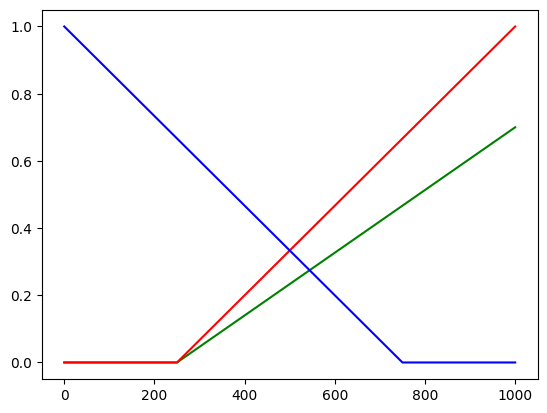

In [125]:
lower_fan_limit = int(fuzzy_blow.low_limit)
upper_fan_limit = int(fuzzy_blow.upp_limit)

x = list(range(lower_fan_limit, upper_fan_limit + 1, 1))
y_fan_out = [fuzzy_fan_speed(current_x) for current_x in x]

plt.plot(x, y_fan_out, 'g-', x, y_fast, 'r-', x, y_slow, 'b-')

как можно видеть, зеленая линия, соответствующая результируюшей функции принадлежности, ниже исходной функции принадлежности.

Аналогично для скорости помпы

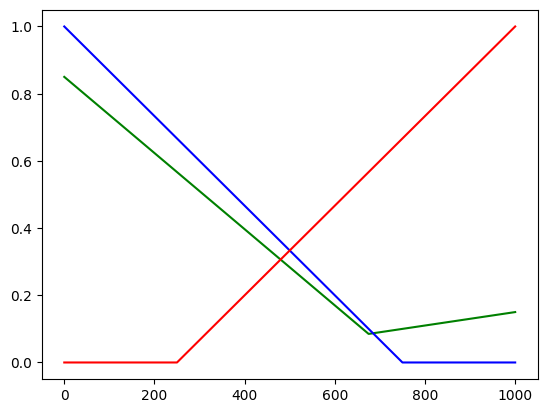

In [126]:
lower_pump_limit = int(fuzzy_pump.low_limit)
upper_pump_limit = int(fuzzy_pump.upp_limit)

x = list(range(lower_fan_limit, upper_fan_limit + 1, 1))
y_pump_out = [fuzzy_pump_speed(current_x) for current_x in x]

plt.plot(x, y_pump_out, 'g-', x, y_slow, 'b-', x, y_fast, 'r-')

Как можно видеть, в данном случае зеленая линия, соответствующая результирующей функции принадлежности, имеет два плеча (более высокое в начале и пониже после 650), так как влажность 15, которую мы задали, одновременно соответствует и низкой, и высокой влажности, причем низкой - в гораздо большей степени.

Осталось найти реальные значения оборотов вентилятора и помпы.

Применим дефаззификацию:

In [127]:
fan_speed = defuzzify(fuzzy_fan_speed)  # по умолчанию используется метод центра тяжести
pump_speed = defuzzify(fuzzy_pump_speed)

print("Fan speed", fan_speed, "pump speed", pump_speed)

Fan speed 753.3333333333335 pump speed 308.7243333643037


Что соответствует графикам

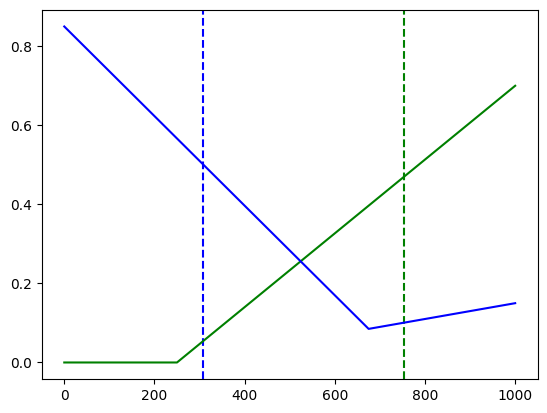

In [128]:
x = list(range(0, 1001, 1))
y_fan_out = [fuzzy_fan_speed(current_x) for current_x in x]
y_pump_out = [fuzzy_pump_speed(current_x) for current_x in x]

plt.axvline(x=753, color='g', ls='--')
plt.axvline(x=308, color='b', ls='--')
plt.plot(x, y_fan_out, 'g-', x, y_pump_out, 'b-')

Вертикальные линии соответствуют дефаззифицированным значениям, и делят соответствующие фигуры на две равные части по площади

Вместо метода центра тяжести для дефаззификации можно использовать метод первого максимума:

In [129]:
fan_speed = defuzzify(fuzzy_fan_speed, first_maximum)
pump_speed = defuzzify(fuzzy_pump_speed, first_maximum)

print("Fan speed", fan_speed, "pump speed", pump_speed)

Fan speed 1000.0 pump speed 0


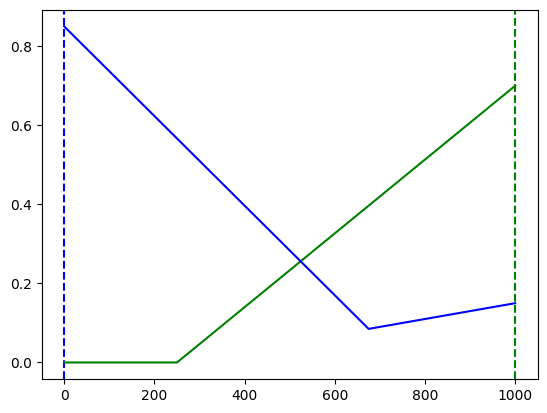

In [130]:
plt.axvline(x=1000, color='g', ls='--')
plt.axvline(x=0, color='b', ls='--')
plt.plot(x, y_fan_out, 'g-', x, y_pump_out, 'b-')

Вертикальные линии соответствуют дефаззифицированным значениям, и равны первым максимумам

При выводе из правил по умолчанию используется механизм вывода Ларсена.

Использование вывода Мамдани выглядит так:

In [133]:
rules = [
    FuzzyRule(temp_is_cold | temp_is_norm, fuzzy_blow, slow, mamdani),  # если холодно или температура нормальная, то скорость вентилятора низкая
    FuzzyRule(temp_is_hot, fuzzy_blow, fast, mamdani),  # если температура высокая, то скорость вентилятора высокая
    FuzzyRule(humidity_is_high, fuzzy_pump, fast, mamdani),  # если влажность высокая, то скорость помпы высокая
    FuzzyRule(humidity_is_low, fuzzy_pump, slow, mamdani),  # если влажность низкая, то скорость помпы выслкая
]

fuzzy_temp.value = 27  # температура в комнате +27 градусов
fuzzy_humidity.value = 15  # и влажность 15 процентов

fuzzy_fan_speed = build_resulting_fuzzy_term(rules, fuzzy_blow)
fuzzy_pump_speed = build_resulting_fuzzy_term(rules, fuzzy_pump)

fan_speed = defuzzify(fuzzy_fan_speed, first_maximum)
pump_speed = defuzzify(fuzzy_pump_speed, first_maximum)

Построим графики

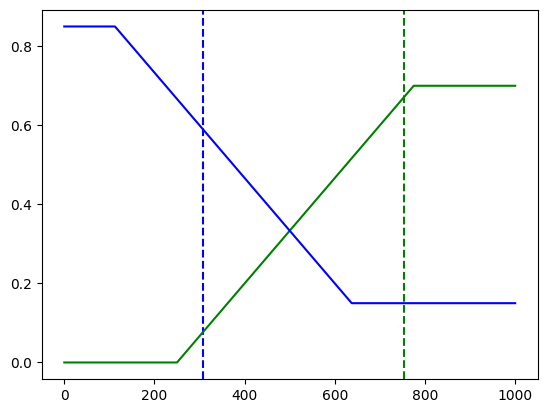

In [134]:
x = list(range(0, 1001, 1))
y_fan_out = [fuzzy_fan_speed(current_x) for current_x in x]
y_pump_out = [fuzzy_pump_speed(current_x) for current_x in x]

plt.axvline(x=753, color='g', ls='--')
plt.axvline(x=308, color='b', ls='--')
plt.plot(x, y_fan_out, 'g-', x, y_pump_out, 'b-')

По сравнению с импликацией Ларсена, графики функций принадлежности не масштабируются, а обрезаются сверху.

Теперь определим нечеткие перменные для нашего робота:

Зададим функции принадлежности для входных переменных:

Опишем нечеткие множества для выходных переменных:

Определим правила:

Зададим значения входных переменных:

Найдем функции принадлежности для выходных переменных и построим их графики:

И найдем соответствуюшие дефаззифицированные значения:

В ячейках выше попробуйте различные механизмы импликации (Ларсена, Мамдани), и различные механизмы дефаззификации (центр тяжести, первого максимума).

Выберите наиболее подходящие для робота.